<a href="https://colab.research.google.com/github/Jlorj/SC1015_MiniProject/blob/main/Happiness_Report_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
from google.colab import files
uploaded1 = files.upload() # Upload HappinessCantrilLadder2005-2020.csv from local drive
uploaded2 = files.upload() # Upload CO2Emissions.csv from local drive

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy import stats

## Setup: Import the Datasets
Dataset on Happiness Index: Attached file <mark>"HappinessCantrilLadder2005-2020.csv"</mark><br/>
Dataset on Internet Users: Attached file <mark>"CO2Emissions.csv"</mark>.

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded1['HappinessCantrilLadder2005-2020.csv']))
df.rename(columns = {'Life satisfaction in Cantril Ladder (World Happiness Report 2021)' : 'Ladder score'}, inplace = True)


dfCO2 = pd.read_csv(io.BytesIO(uploaded2['CO2Emissions.csv']))
dfCO2. rename(columns = {'iso_code':'Code', 'year':'Year'}, inplace = True)


df2Sliced = dfCO2[["Code", "Year", "co2_per_capita"]]


dfCO2andHappiness = pd.merge(df, df2Sliced, on=["Year", 'Code'], how='left')
dfCO2andHappiness


,Entity,Code,Year,Ladder score,co2_per_capita
0,Afghanistan,AFG,2008,3.724,0.152
1,Afghanistan,AFG,2009,4.402,0.237
2,Afghanistan,AFG,2010,4.758,0.288
3,Afghanistan,AFG,2011,3.832,0.402
4,Afghanistan,AFG,2012,3.783,0.328
...,...,...,...,...,...
2036,Zimbabwe,ZWE,2016,3.735,0.765
2037,Zimbabwe,ZWE,2017,3.638,0.673
2038,Zimbabwe,ZWE,2018,3.616,0.821
2039,Zimbabwe,ZWE,2019,2.694,0.748


Drop the rows with Nan values.<br/>
Update the dfCO2andHappiness dataframe to only store the columns <mark>"Ladder score"</mark> and <mark>"co2_per_capita"</mark>

In [ ]:
dfCO2andHappiness.dropna(inplace=True)
dfCO2andHappiness = dfCO2andHappiness[["Ladder score", "co2_per_capita"]]
dfCO2andHappiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1924 entries, 0 to 2040
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ladder score    1924 non-null   float64
 1   co2_per_capita  1924 non-null   float64
dtypes: float64(2)
memory usage: 45.1 KB


# Exploratory Data Analysis
Replace Czech Republic,  Taiwan, Taiwan Province of China, Hong Kong S.A.R. of China, Ivory Coast, Macedonia, Palestinian Territories, Swaziland Names in HappinessReport dataset

In [ ]:
# old code
""" 
dfCO2 = pd.read_csv(io.BytesIO(uploaded2['CO2Emissions.csv']), index_col = 1)

dfCO2Filtered = dfCO2[dfCO2["year"] == 2020]
dfCO2Filtered.drop_duplicates()

dfCO2Filtered = dfCO2Filtered.rename(columns={"country": "Country name"})

dfCO2Filtered.head()
dfCO2andHappiness = pd.merge(df, dfCO2Filtered, left_index=True, right_index=True, how='left')[["Ladder score","co2_per_capita"]]

#Replace Czech Republic Data
dfCO2andHappiness.loc["Czech Republic","co2_per_capita"]  = dfCO2Filtered.loc["Czechia","co2_per_capita"]
dfCO2andHappiness[(np.abs(stats.zscore(dfCO2andHappiness)) < 3).all(axis=1)]

dfCO2andHappiness[dfCO2andHappiness["co2_per_capita"].isnull()]
dfCO2andHappiness.dropna(inplace = True)

dfCO2andHappiness
"""

' \ndfCO2 = pd.read_csv(io.BytesIO(uploaded2[\'CO2Emissions.csv\']), index_col = 1)\n\ndfCO2Filtered = dfCO2[dfCO2["year"] == 2020]\ndfCO2Filtered.drop_duplicates()\n\ndfCO2Filtered = dfCO2Filtered.rename(columns={"country": "Country name"})\n\ndfCO2Filtered.head()\ndfCO2andHappiness = pd.merge(df, dfCO2Filtered, left_index=True, right_index=True, how=\'left\')[["Ladder score","co2_per_capita"]]\n\n#Replace Czech Republic Data\ndfCO2andHappiness.loc["Czech Republic","co2_per_capita"]  = dfCO2Filtered.loc["Czechia","co2_per_capita"]\ndfCO2andHappiness[(np.abs(stats.zscore(dfCO2andHappiness)) < 3).all(axis=1)]\n\ndfCO2andHappiness[dfCO2andHappiness["co2_per_capita"].isnull()]\ndfCO2andHappiness.dropna(inplace = True)\n\ndfCO2andHappiness\n'

<mark>Anomaly Detection</mark> Using <mark>Isolation Forest</mark>

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
# Estimation of the anomaly population of the dataset (necessary for IsolationForest)
contamination = 0.01
# Copy dfCO2andHappiness into a temporary dataframe
df = dfCO2andHappiness.copy()
df.head()

,Ladder score,co2_per_capita
0,3.724,0.152
1,4.402,0.237
2,4.758,0.288
3,3.832,0.402
4,3.783,0.328


In [ ]:
# Model Training
model = IsolationForest(contamination=contamination)
model.fit(df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.01)

In [ ]:
# Prediction
df["Anomalies_scores"] = model.decision_function(df[["Ladder score", "co2_per_capita"]])
df["Anomaly"] = model.predict(df[["Ladder score", "co2_per_capita"]])
df.head()

,Ladder score,co2_per_capita,Anomalies_scores,Anomaly
0,3.724,0.152,0.182983,1
1,4.402,0.237,0.226718,1
2,4.758,0.288,0.224318,1
3,3.832,0.402,0.179917,1
4,3.783,0.328,0.178260,1


In [ ]:
dfCO2andHappiness["Anomaly"] = df["Anomaly"]
dfCO2andHappiness.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Ladder score,co2_per_capita,Anomaly
0,3.724,0.152,1
1,4.402,0.237,1
2,4.758,0.288,1
3,3.832,0.402,1
4,3.783,0.328,1


In [ ]:
# Removing the Anomalies
dfCO2andHappiness = dfCO2andHappiness[dfCO2andHappiness.Anomaly == 1]
dfCO2andHappiness.head()
del dfCO2andHappiness["Anomaly"]
dfCO2andHappiness.head()
dfCO2andHappiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1904 entries, 0 to 2040
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ladder score    1904 non-null   float64
 1   co2_per_capita  1904 non-null   float64
dtypes: float64(2)
memory usage: 44.6 KB


Explore the response variable <mark>"Ladder score"</mark>.

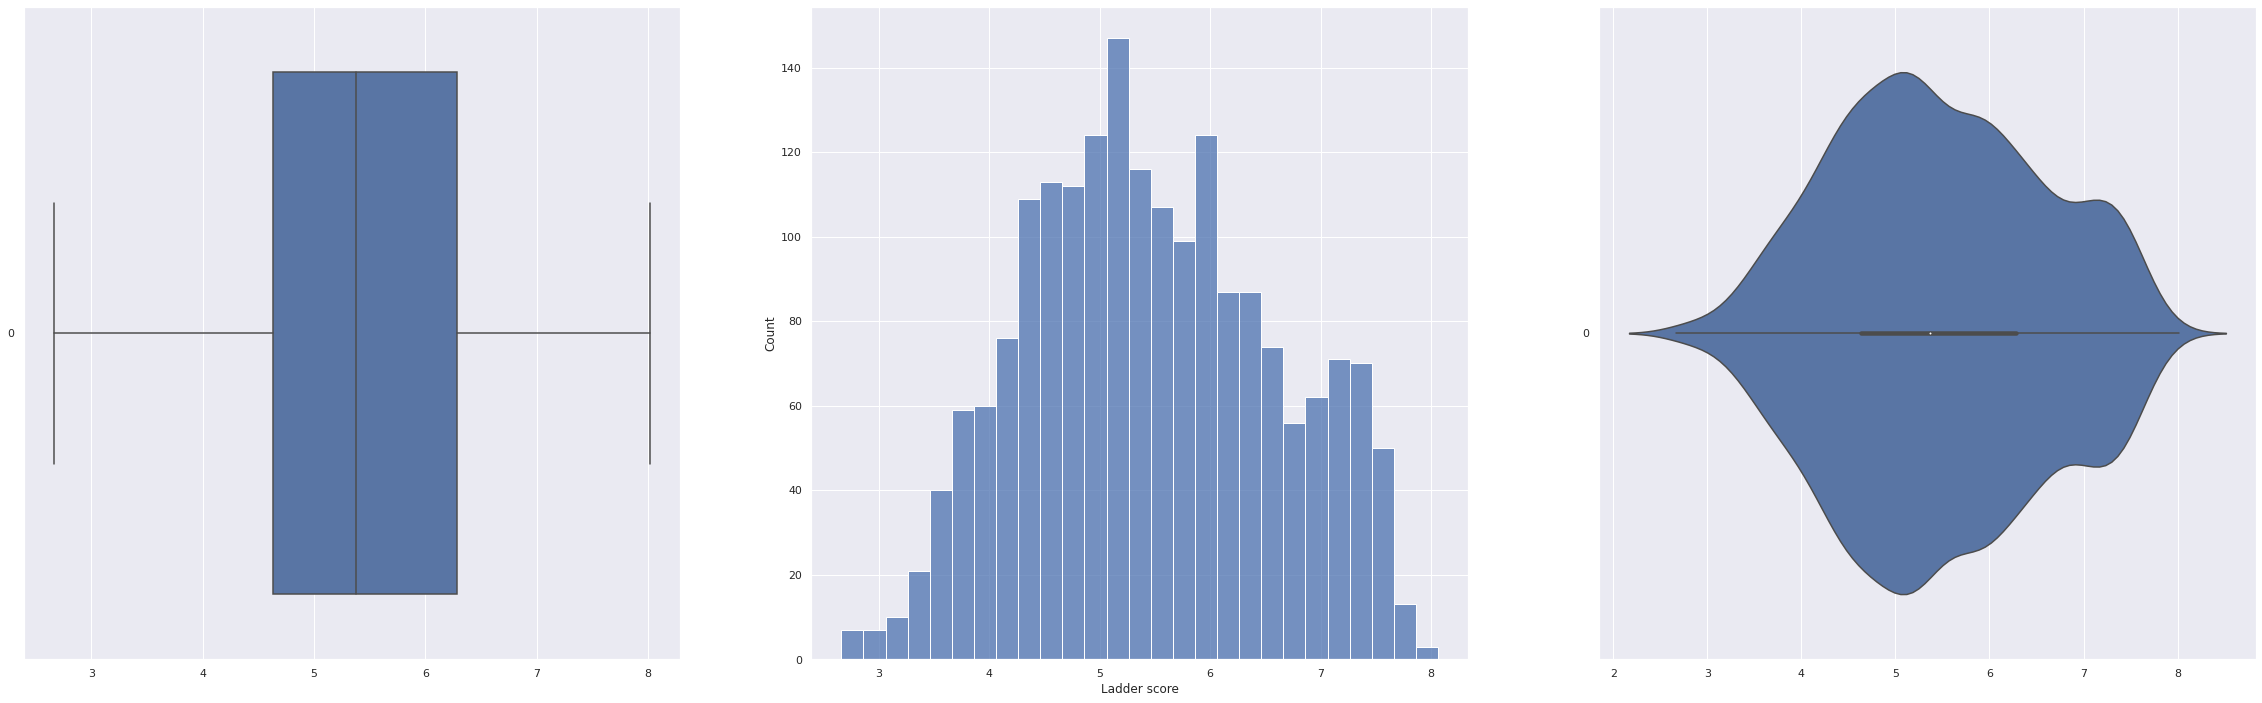

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["Ladder score"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['Ladder score'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["Ladder score"], orient = "h", ax = axes[2])

Explore the predicor variable <mark>"co2_per_capita"</mark>.

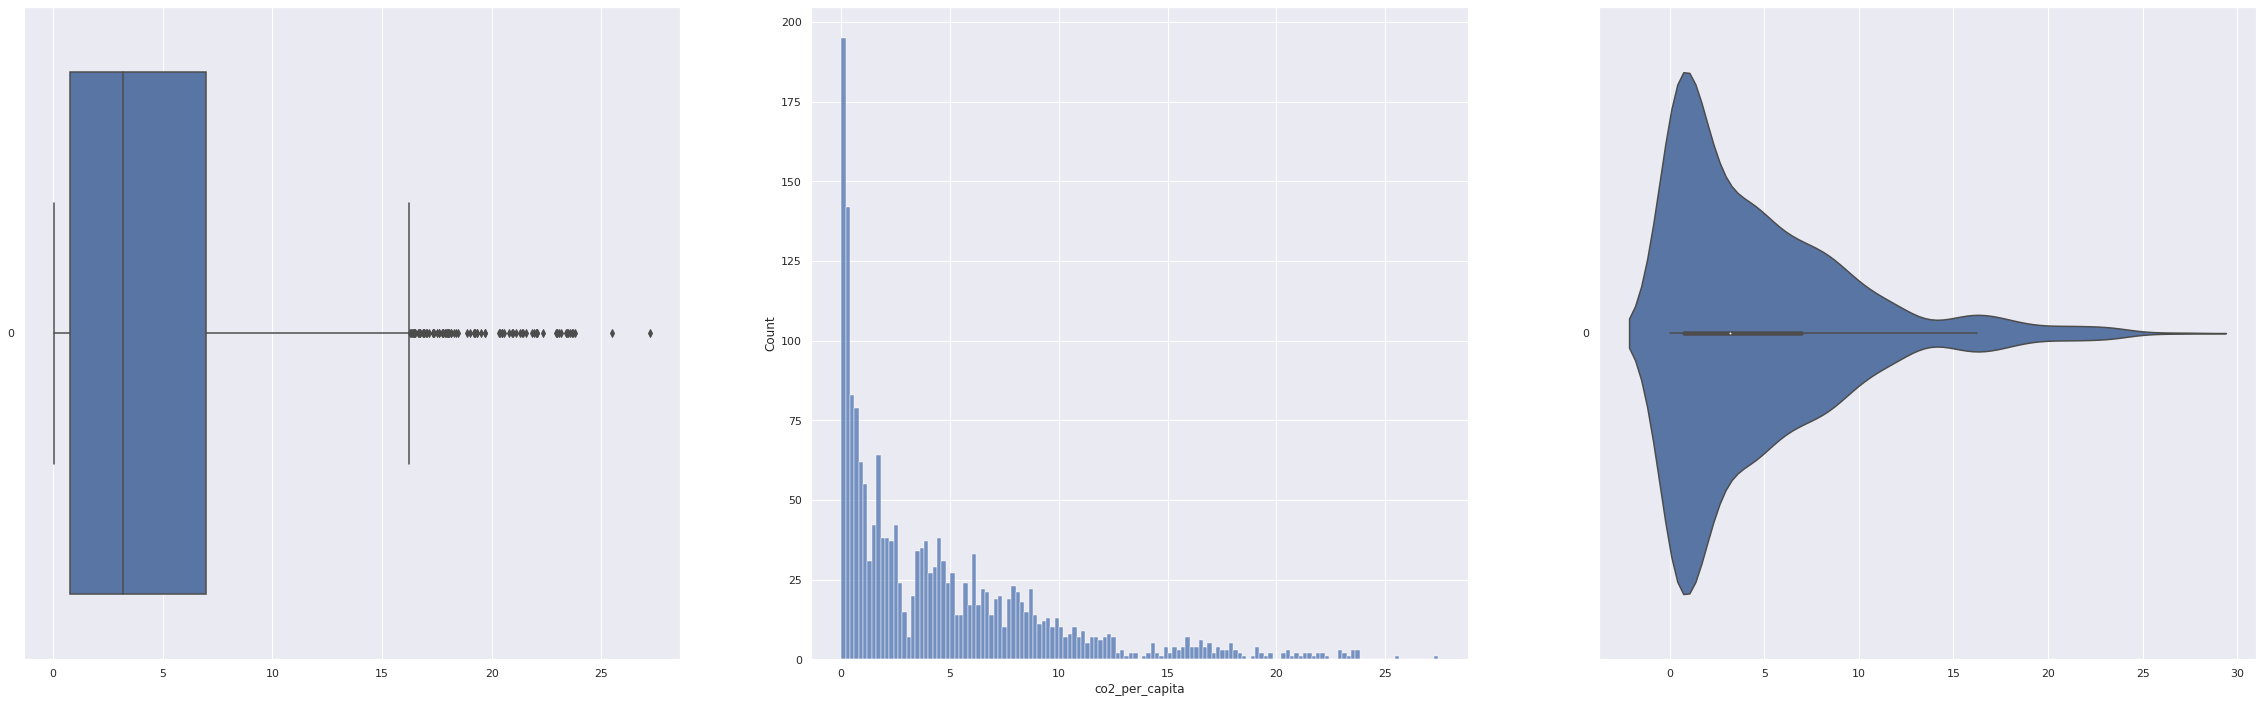

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["co2_per_capita"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['co2_per_capita'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["co2_per_capita"], orient = "h", ax = axes[2])

Find rows that are <mark>outliers</mark> and remove them

In [ ]:
noMoreOutliers = True
while True:
  noMoreOutliers = True
  LadderScore_q3, LadderScore_q1 = np.percentile(dfCO2andHappiness["Ladder score"], [75, 25])
  CO2PerCapita_q3, CO2PerCapita_q1 = np.percentile(dfCO2andHappiness["co2_per_capita"], [75, 25])
  LadderScore_iqr = LadderScore_q3 - LadderScore_q1
  CO2PerCapita_iqr = CO2PerCapita_q3 - CO2PerCapita_q1
  deleteRow = False
  countries_to_remove = []
  for index, row in dfCO2andHappiness.iterrows():
      deleteRow = False
      if (row["Ladder score"] <= LadderScore_q1 - 1.5*LadderScore_iqr) or (row["Ladder score"] >= LadderScore_q3 + 1.5*LadderScore_iqr):
          deleteRow = True
      if (row["co2_per_capita"] <= CO2PerCapita_q1 - 1.5*CO2PerCapita_iqr) or (row["co2_per_capita"] >= CO2PerCapita_q3 + 1.5*CO2PerCapita_iqr):
          deleteRow = True
      if deleteRow == True:
          noMoreOutliers = False
          countries_to_remove.append(index)
  for country in countries_to_remove:
      dfCO2andHappiness.drop(index = country, inplace = True)
  if noMoreOutliers:
    break

Explore the response variable <mark>"Ladder score"</mark>.

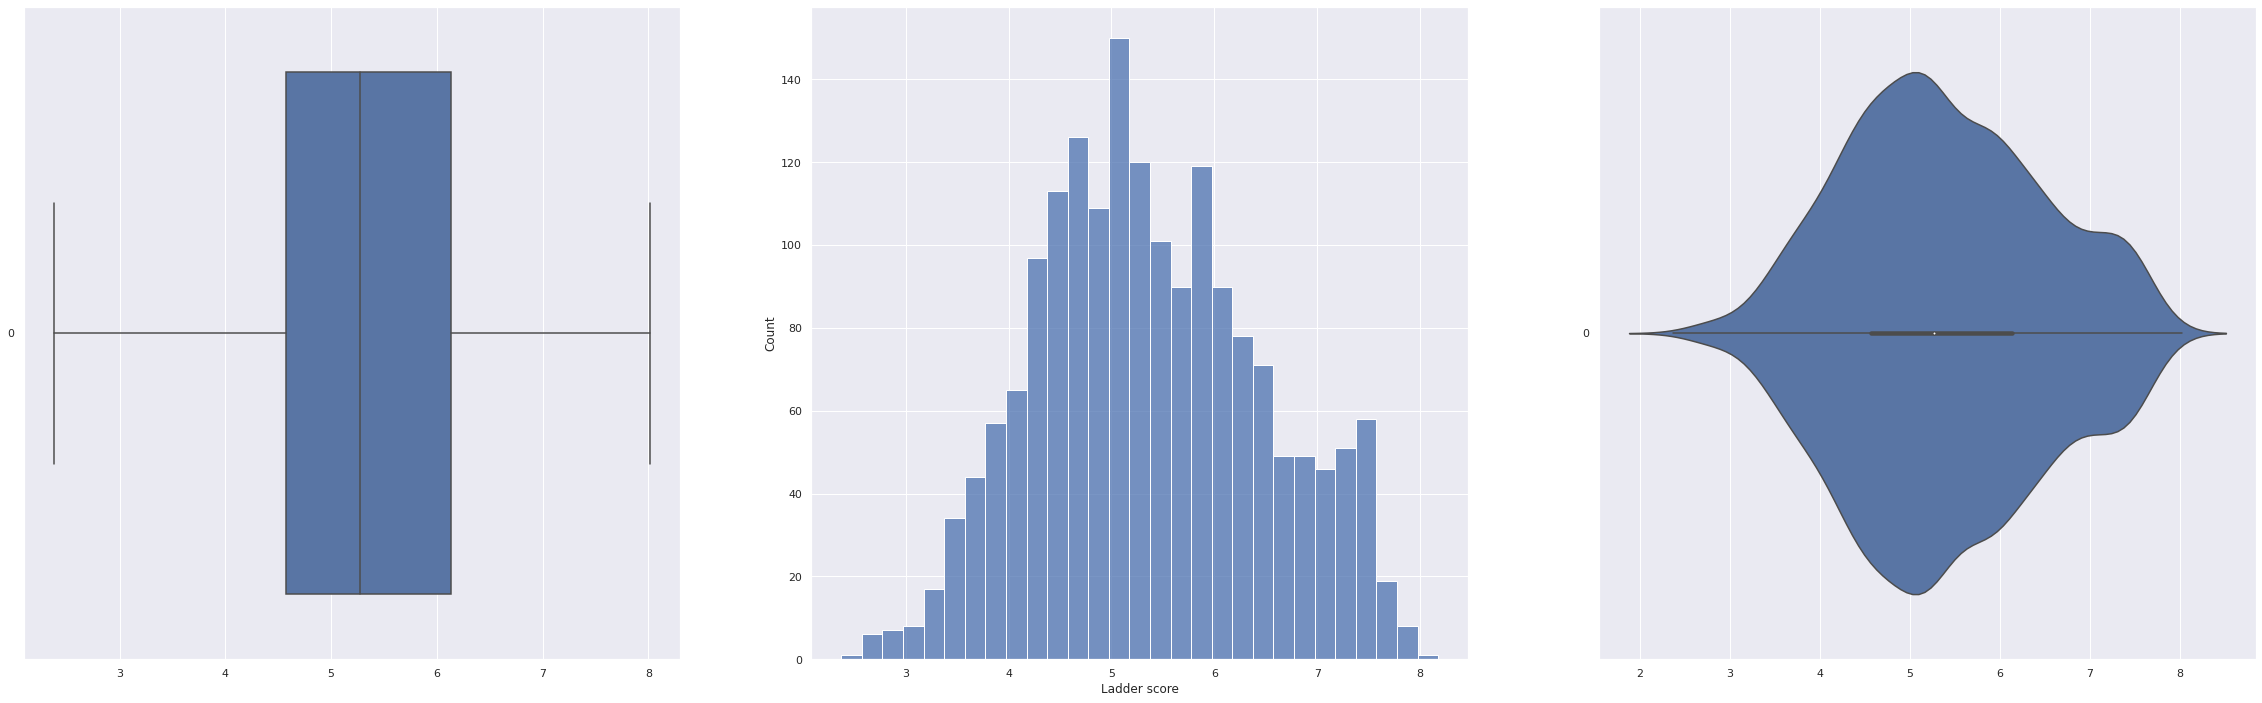

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["Ladder score"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['Ladder score'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["Ladder score"], orient = "h", ax = axes[2])

Explore the response variable <mark>"co2_per_capita"</mark>.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 0 to 2040
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ladder score    1781 non-null   float64
 1   co2_per_capita  1781 non-null   float64
dtypes: float64(2)
memory usage: 106.3 KB


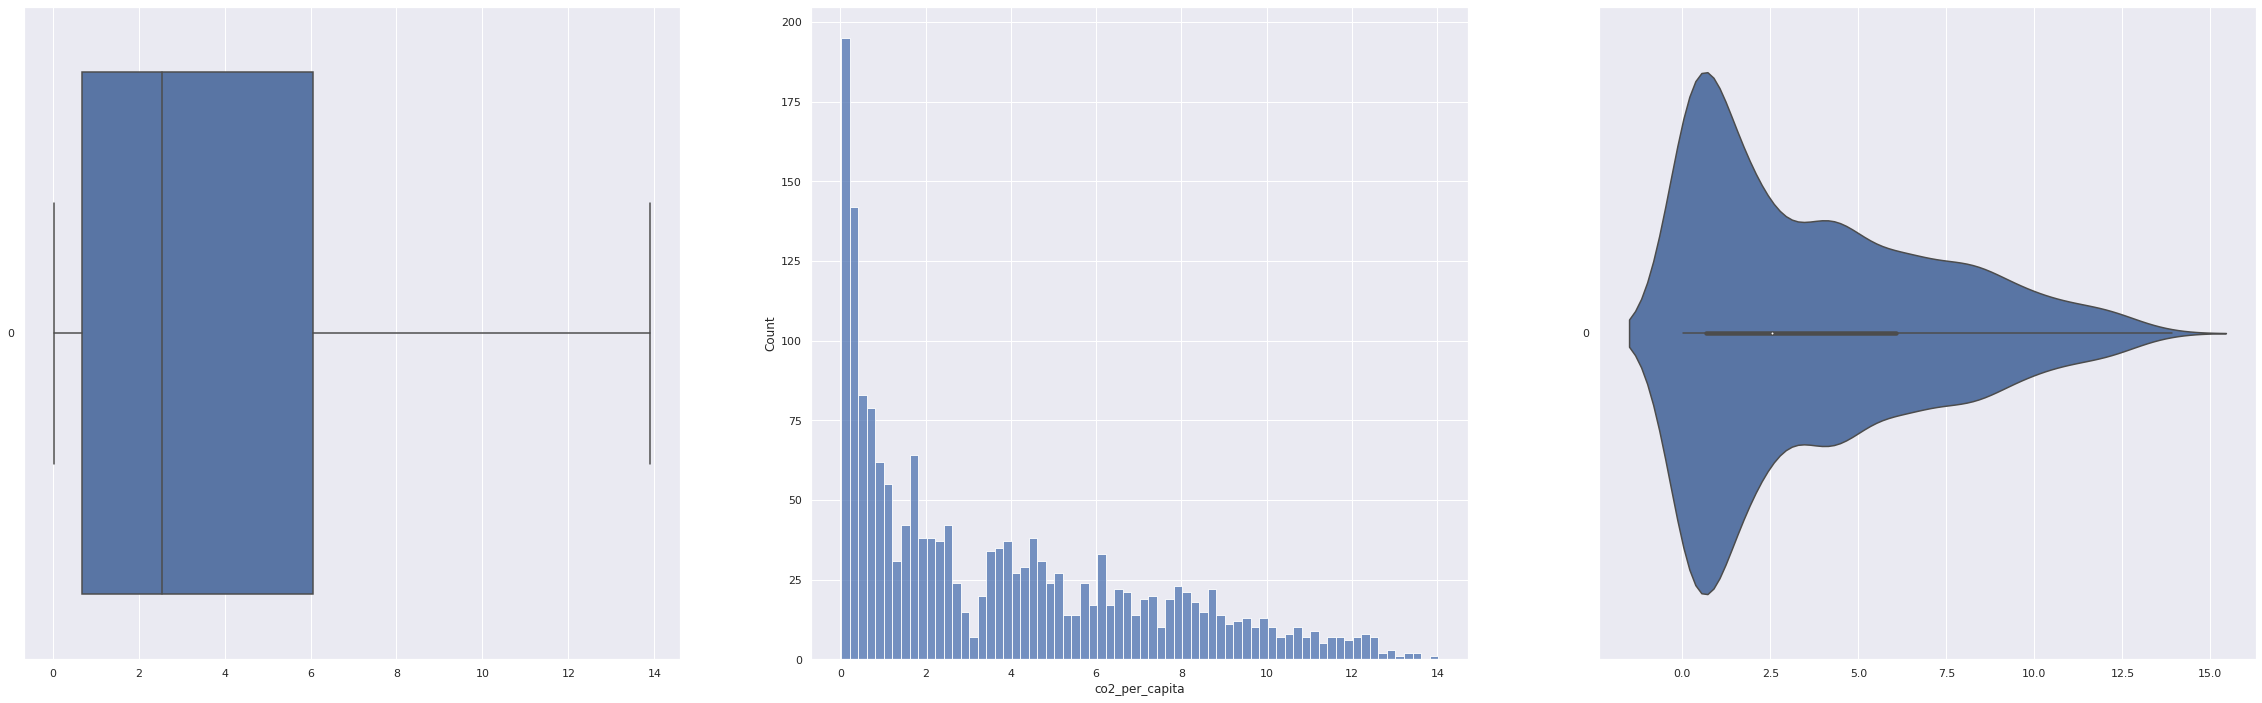

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["co2_per_capita"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['co2_per_capita'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["co2_per_capita"], orient = "h", ax = axes[2])

<mark>dfCO2andHappiness</mark> is now outlier free


Joinplot of <mark>"Ladder score"</mark> against <mark>"co2_per_capita"</mark>

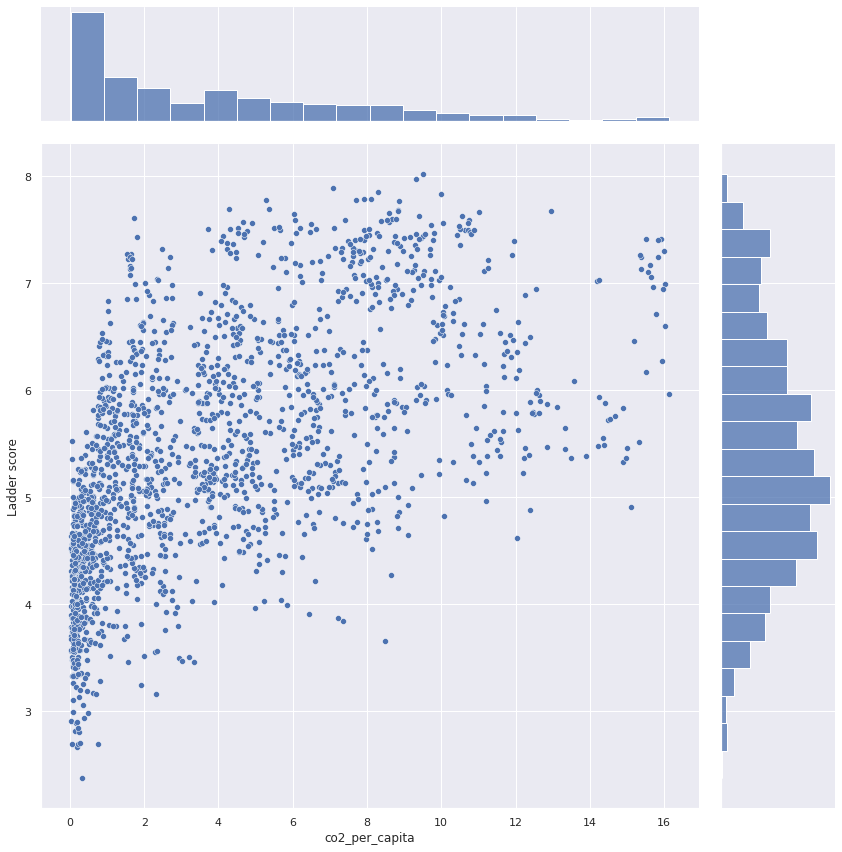

In [ ]:
sb.jointplot(data = dfCO2andHappiness, x = "co2_per_capita", y = "Ladder score", height = 12)

Calculate the <mark>correlation</mark> between the two variables

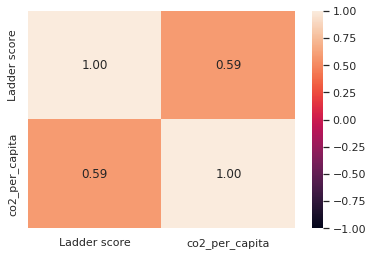

In [ ]:
sb.heatmap(dfCO2andHappiness.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Train Set : (1455, 1) (1455, 1)
Test Set  : (364, 1) (364, 1)
Intercept of Regression 	: b =  [-6.83952402]
Coefficients of Regression 	: a =  [[1.99883895]]



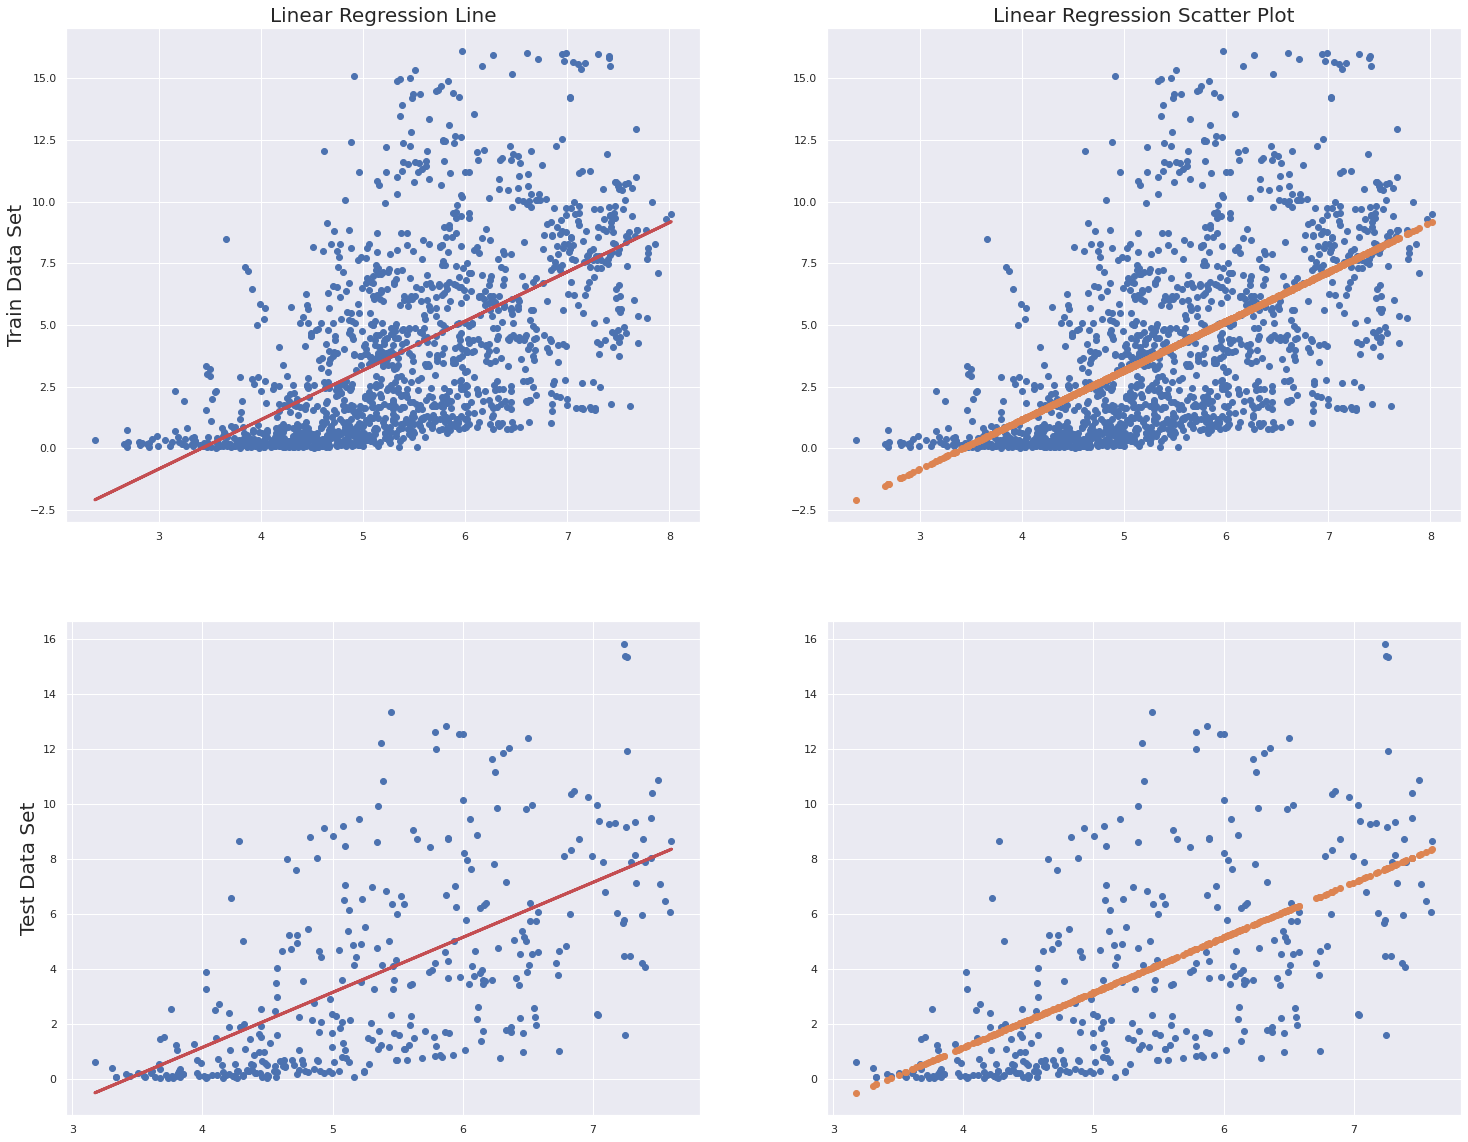

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3428235579729372
Mean Squared Error (MSE) 	: 9.413307480626191
Root Mean Squared Error (RMSE) 	: 3.068111386606782

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3844883581635955
Mean Squared Error (MSE) 	: 7.97492864023363
Root Mean Squared Error (RMSE) 	: 2.823991614759794


The higher the variance, the 'less good' the fit is.
The lower the MSE, the more accurate the model is.


In [ ]:
traindf = dfCO2andHappiness.dropna()
gla = pd.DataFrame(traindf['Ladder score']) 
sp = pd.DataFrame(traindf['co2_per_capita']) 
sp.head()

X_train, X_test, y_train, y_test = train_test_split(gla, sp, test_size = 0.2, shuffle = True)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model




# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Assign X-train data into regine_x
regline_x = X_train

# FOR TRAINED DATA SET
# !! For LINE GRAPH
regline_y = linreg.coef_ * X_train + linreg.intercept_
f, axes = plt.subplots(2, 2, figsize=(25, 20))
axes[0,0].scatter(X_train, y_train)
axes[0,0].plot(regline_x, regline_y, 'r-', linewidth = 3)
axes[0,0].set_title("Linear Regression Line", fontsize=20)
axes[0,0].set_ylabel("Train Data Set", fontsize=20)

# !! For PREDICTED SCATTER LINE
y_train_pred = linreg.predict(X_train)
axes[0,1].scatter(X_train, y_train)
axes[0,1].scatter(X_train, y_train_pred)
axes[0,1].set_title("Linear Regression Scatter Plot", fontsize=20)

## FOR TEST DATA SET
regline_xtest = X_test
y_test_pred = linreg.predict(X_test)

axes[1,0].scatter(X_test, y_test)
axes[1,0].plot(regline_xtest, y_test_pred, 'r-', linewidth = 3)
axes[1,0].set_ylabel("Test Data Set", fontsize=20)

axes[1,1].scatter(X_test, y_test)
axes[1,1].scatter(regline_xtest, y_test_pred)
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", mean_squared_error(y_train, y_train_pred, squared = False))

print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", mean_squared_error(y_test, y_test_pred, squared = False))

print()

print("""
The higher the variance, the 'less good' the fit is.
The lower the MSE, the more accurate the model is.""")


GoodnessTrain1 = linreg.score(X_train, y_train)
AccuracyTrain1 = mean_squared_error(y_train, y_train_pred, squared = False)
GoodnessTest1 = linreg.score(X_test, y_test)
AccuracyTest1 = mean_squared_error(y_test, y_test_pred, squared = False)